In [3]:
import random
import warnings
warnings.filterwarnings('ignore')

import requests
import torch
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn.functional import linear
from torch.nn.functional import softmax,relu

from models.backbone import Backbone, Joiner
from models.detr import DETR
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from predict_utils import transform, rescale_bboxes, detect, plot_results, CLASSES
from util.misc import (NestedTensor, nested_tensor_from_tensor_list)

torch.set_grad_enabled(False)
%matplotlib inline

In [4]:
hidden_dim = 256
dropout = 0.1
nheads = 8
dim_feedforward = 2048
enc_layers = 6
dec_layers = 6
pre_norm = False
num_classes = 91  # coco
num_queries = 100
aux_loss = False

In [5]:
backbone = Backbone('resnet50', True, False, False)

In [6]:
N_steps = hidden_dim // 2
position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
model = Joiner(backbone, position_embedding)
model.num_channels = backbone.num_channels
backbone = model

In [7]:
transformer = Transformer(
    d_model=hidden_dim,
    dropout=dropout,
    nhead=nheads,
    dim_feedforward=dim_feedforward,
    num_encoder_layers=enc_layers,
    num_decoder_layers=dec_layers,
    normalize_before=pre_norm,
    return_intermediate_dec=True,
)

In [8]:
model = DETR(
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=num_queries,
    aux_loss=aux_loss,
)

In [9]:
model.load_state_dict(torch.load("E:\Development Program\Pycharm Program\detr\detr-r50-e632da11.pth")['model'])
model.eval();

In [10]:
from PIL import Image
import requests
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [11]:
from predict_utils import transform, rescale_bboxes
img = transform(im).unsqueeze(0)
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

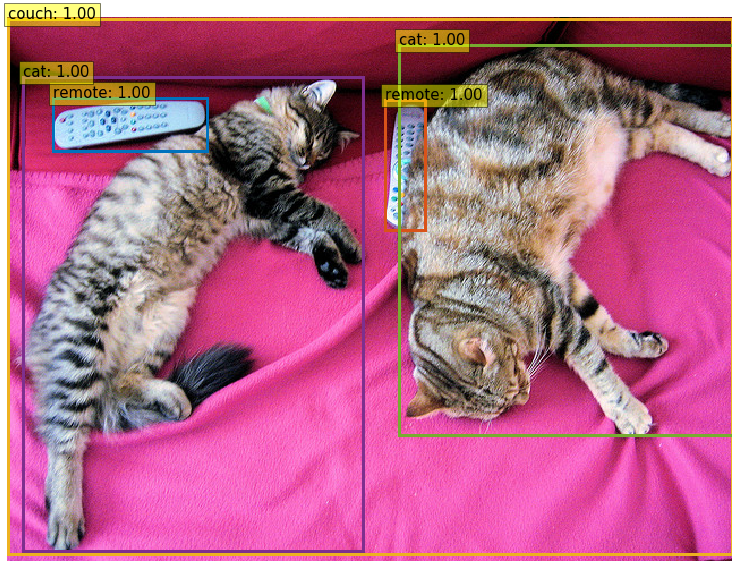

In [12]:
from predict_utils import plot_results
plot_results(im, probas[keep], bboxes_scaled)

In [13]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []
cq = []  # 存储detr中的 cq
pk = []  # 存储detr中的 encoder pos
memory = []  # 存储encoder的输出特征图memory
enc_att_in=[]

In [14]:
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.register_forward_hook(
        lambda self, input, output: memory.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_att_in.append(input[1])
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].norm1.register_forward_hook(
        lambda self, input, output: cq.append(output)
    ),
    model.backbone[-1].register_forward_hook(
        lambda self, input, output: pk.append(output)
    ),
]

In [15]:
outputs = model(img)
for hook in hooks:
    hook.remove()
conv_features = conv_features[0]  # [1,2048,25,34]
enc_attn_weights = enc_attn_weights[0]  # [1,850,850]   : [N,L,S]
dec_attn_weights = dec_attn_weights[0]  # [1,100,850]   : [N,L,S] --> [batch, tgt_len, src_len]
memory = memory[0]  # [850,1,256]
cq = cq[0]  # decoder的self_attn:最后一层输出[100,1,256]
pk = pk[0]  # [1,256,25,34]
enc_att_in=enc_att_in[0]

In [16]:
h, w = conv_features['0'].tensors.shape[-2:]

In [17]:
feature_map=conv_features['0'].tensors
feature_map[-1:].size()

torch.Size([1, 2048, 25, 34])

In [18]:
input_emb=model.input_proj(feature_map)
input_emb.size()

torch.Size([1, 256, 25, 34])

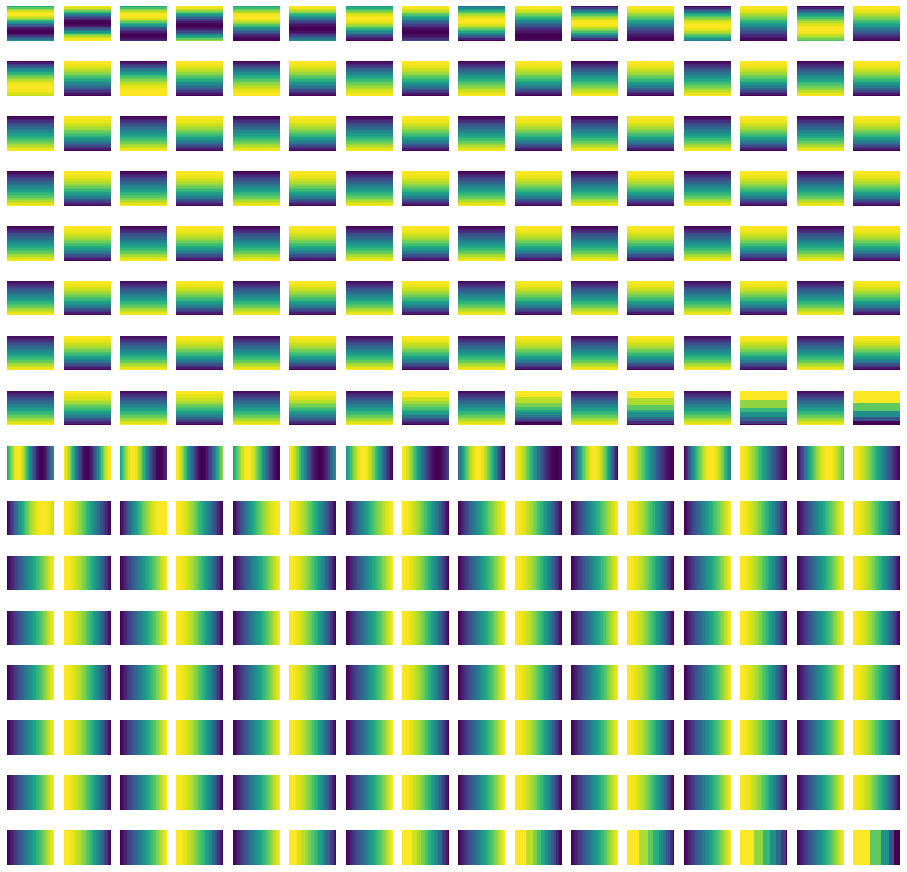

In [19]:
fig, axs = plt.subplots(ncols=16, nrows=16,figsize=(16,16))
_pk=pk.squeeze(0)
i=0
while i<256:
    ax = axs[i//16][i%16]
    ax.imshow(_pk[i])
    i+=1
    ax.axis('off')

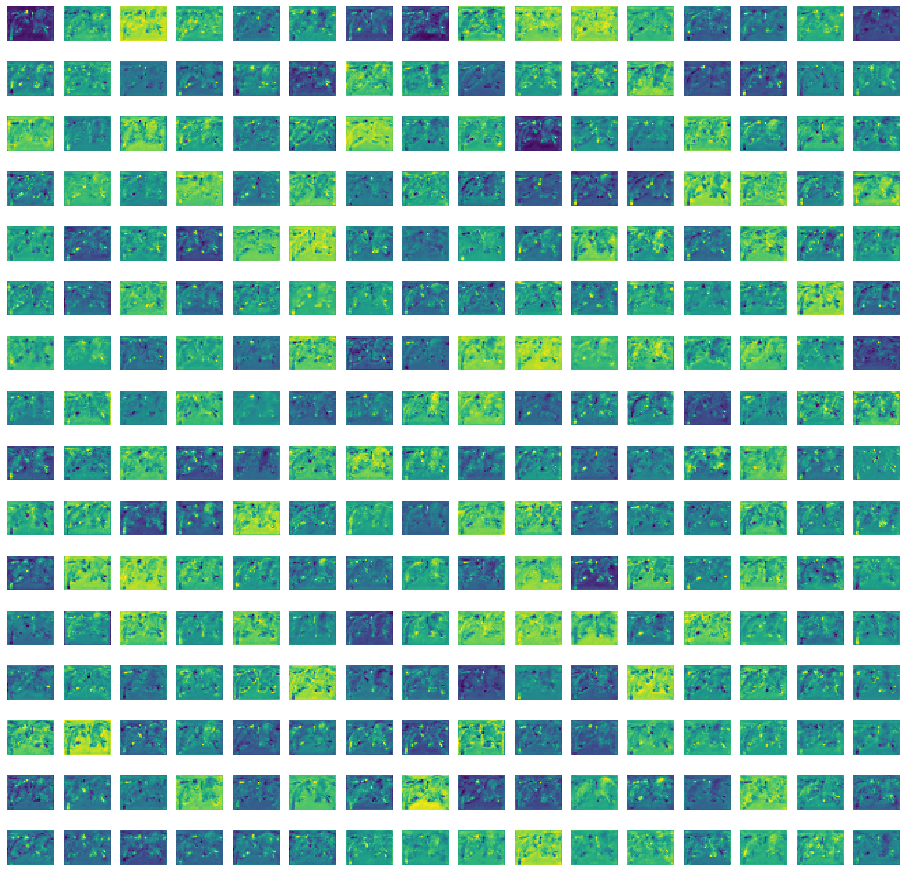

In [20]:
fig, axs = plt.subplots(ncols=16, nrows=16,figsize=(16,16))
_input_emb=input_emb.squeeze(0)
i=0
while i<256:
    ax = axs[i//16][i%16]
    ax.imshow(_input_emb[i])
    i+=1
    ax.axis('off')

In [21]:
input_emb,mask = nested_tensor_from_tensor_list(input_emb).decompose()

In [22]:
src = input_emb
bs, c, h, w = src.shape
src = src.flatten(2).permute(2, 0, 1)
pos_embed = pk.flatten(2).permute(2, 0, 1)
query_embed=model.query_embed.weight
query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
mask = mask.flatten(1)
tgt = torch.zeros_like(query_embed)

In [23]:
q = k = src+pos_embed
v=src
q.size()

torch.Size([850, 1, 256])

In [24]:
in_proj_weight=0
in_proj_bias=0
for name, parameters in model.named_parameters():
    if name == 'transformer.encoder.layers.5.self_attn.in_proj_weight':
        in_proj_weight = parameters
    if name == 'transformer.encoder.layers.5.self_attn.in_proj_bias':
        in_proj_bias = parameters
    if name == 'transformer.encoder.layers.5.self_attn.out_proj_weight':
        out_proj_weight = parameters
    if name == 'transformer.encoder.layers.5.self_attn.out_proj_bias':
        out_proj_bias = parameters

In [25]:
w_q, w_k, w_v = in_proj_weight.chunk(3)
b_q, b_k, b_v = in_proj_bias.chunk(3)
q,k,v = linear(q, w_q, b_q), linear(k, w_k, b_k),linear(v, w_v, b_v)

In [26]:
tgt_len, bsz, embed_dim = q.shape
num_heads=nheads
head_dim = embed_dim // num_heads
q_1 = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
k_1 = k.contiguous().view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
v_1 = v.contiguous().view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
src_len = k_1.size(1)

In [27]:
q_1.size(),k_1.transpose(-2, -1).shape

(torch.Size([8, 850, 32]), torch.Size([8, 32, 850]))

In [28]:
B, Nt, E = q_1.shape
attn = torch.bmm(q_1, k_1.transpose(-2, -1))

In [29]:
attn.size()

torch.Size([8, 850, 850])

In [30]:
_attn=attn
# _attn = softmax(attn, dim=-1)
_attn = relu(attn)

In [31]:
output = torch.bmm(_attn, v_1)
attn_output=output

In [32]:
attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, embed_dim)
attn_output = model.transformer.encoder.layers[-1].self_attn.out_proj(attn_output)
attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))

In [33]:
attn_output.shape

torch.Size([850, 1, 256])

In [34]:
attn_output_weights = _attn.view(bsz, num_heads, tgt_len, src_len)
bsz, num_heads, tgt_len, src_len

(1, 8, 850, 850)

In [35]:
attn_output_heads=attn_output_weights.squeeze(0)

In [36]:
attn_output_weights = attn_output_weights.sum(dim=1) / num_heads

In [37]:
attn_output_weights.size()

torch.Size([1, 850, 850])

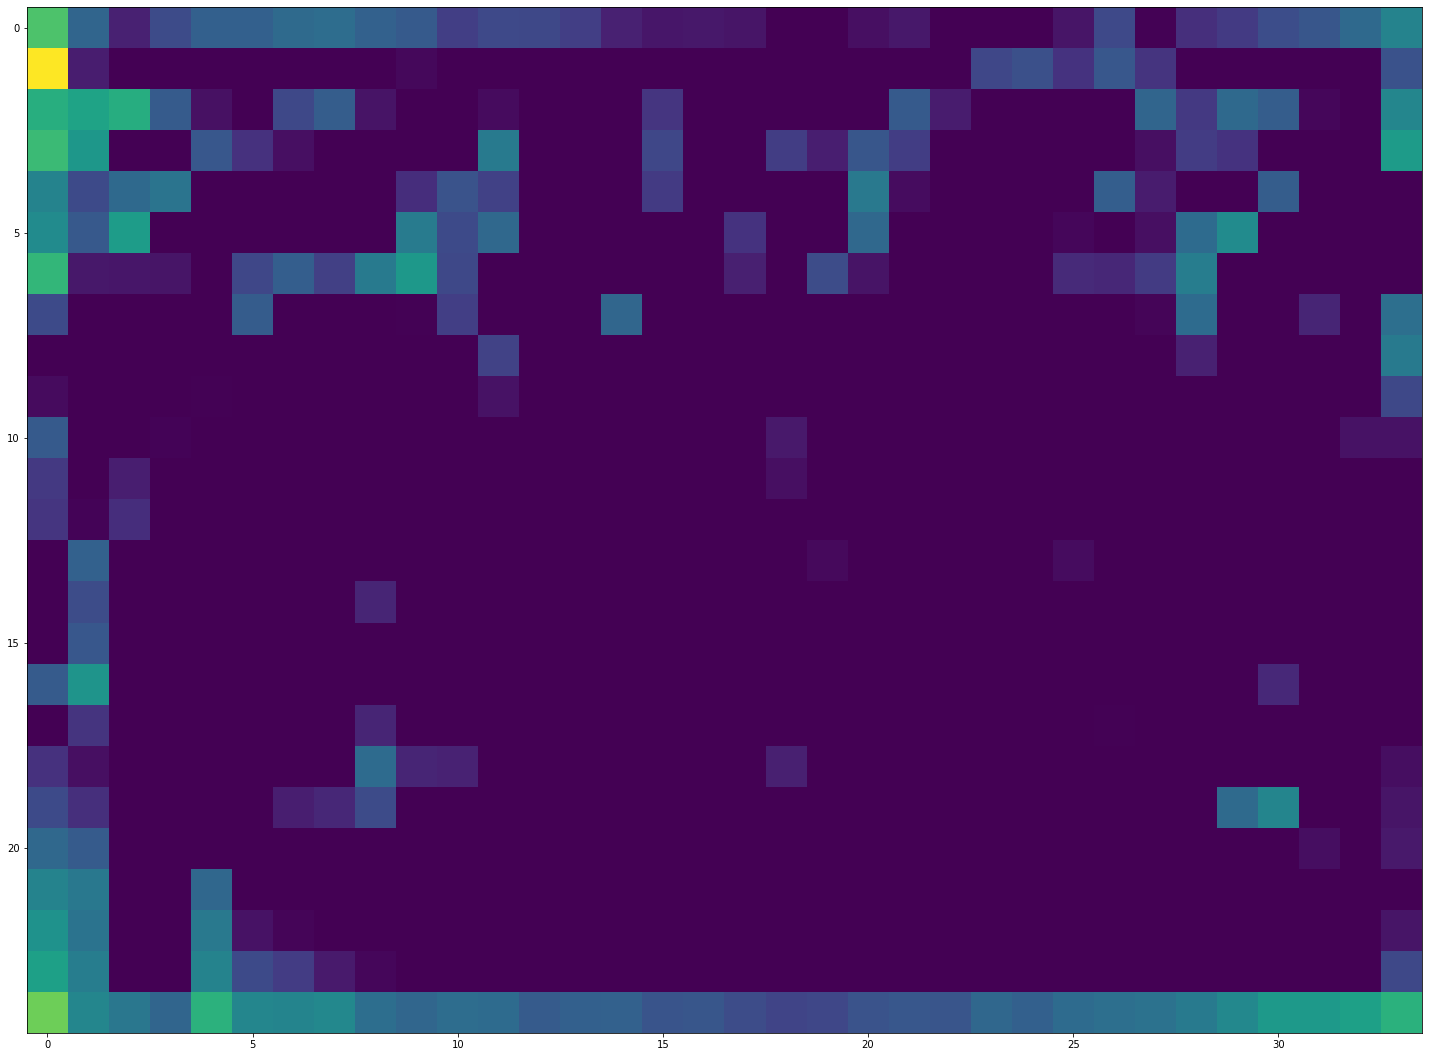

In [38]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(h,w))
axs.imshow(attn_output_heads[5][8*34+25,:].view(25,34))  # 该点位于第5+1个头，第8+1行，第25+1列

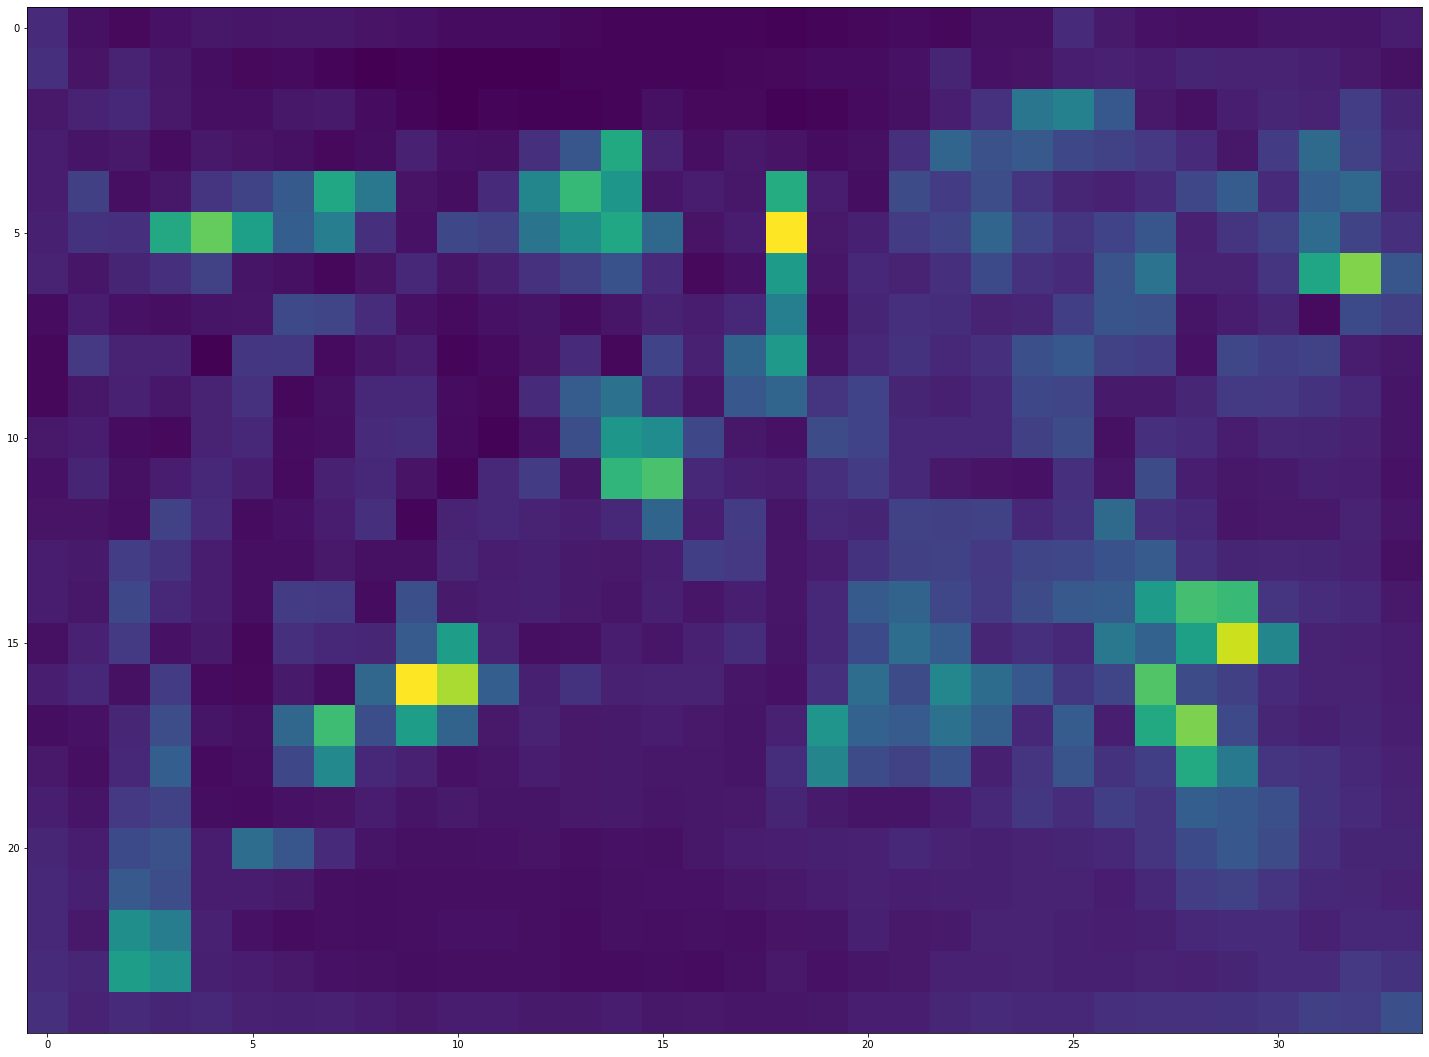

In [39]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(h,w))
axs.imshow(attn_output_weights[0][8*34+25,:].view(25,34))

### 沿用错误的思路，如果说认为输出的长度为256的话，会看到一下情况

In [40]:
q1=q[:,:,199].unsqueeze(-1)
print('q1:',q1.size(),'\nk:',k.size())

q1: torch.Size([850, 1, 1]) 
k: torch.Size([850, 1, 256])


In [41]:
relation=[]
for i in range(0,256):
    relation.append(torch.dot(q[:,0,5],k[:,0,i]))
relation_map=torch.tensor(relation).unsqueeze(0)
relation_map.size()

torch.Size([1, 256])

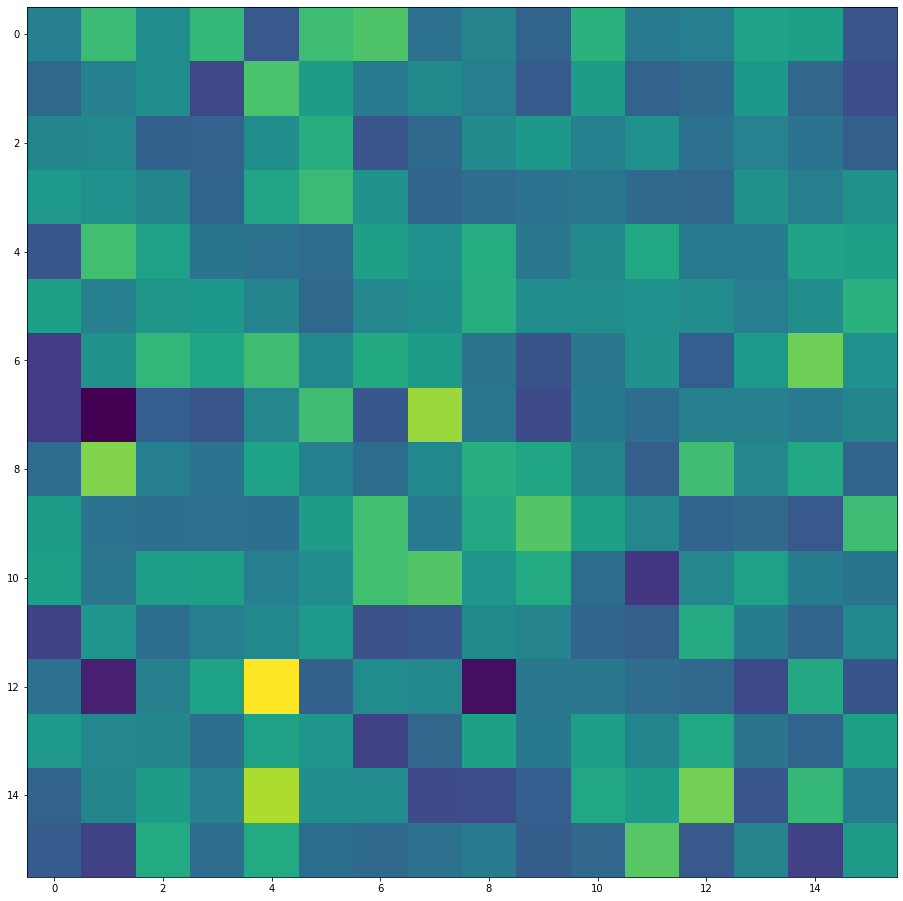

In [42]:
fig, axs = plt.subplots(ncols=1, nrows=1,figsize=(16,16))
axs.imshow(relation_map.view(16,16))

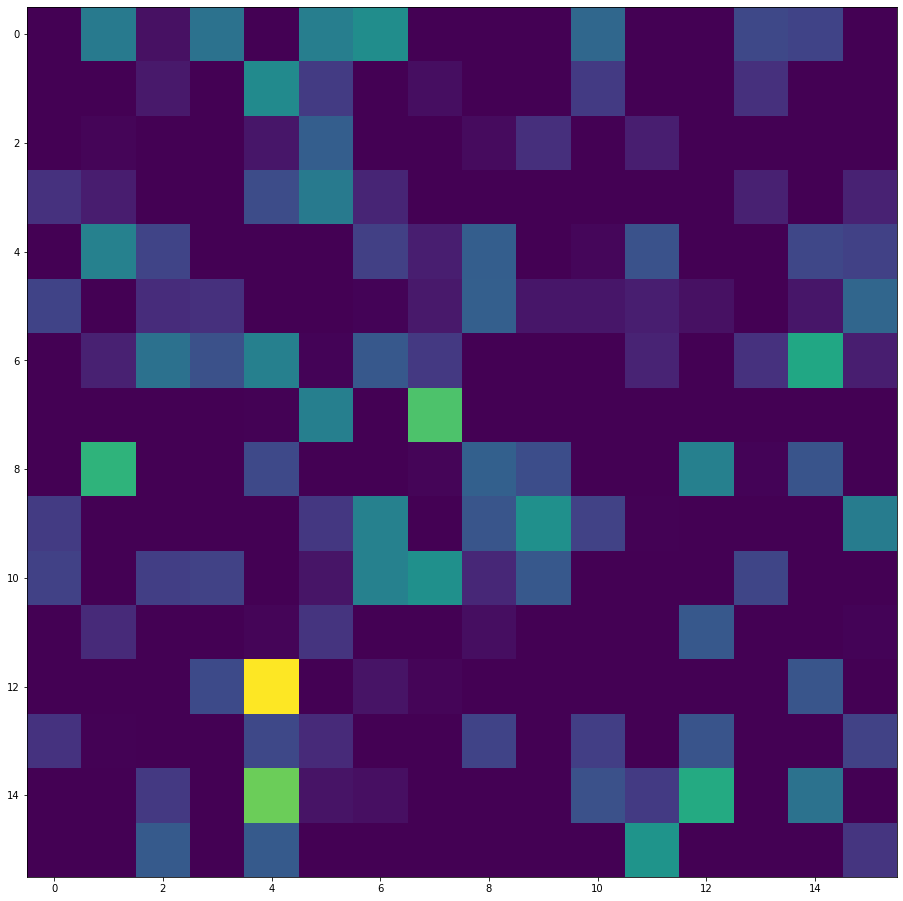

In [43]:
fig, axs = plt.subplots(ncols=1, nrows=1,figsize=(16,16))
axs.imshow(relu(relation_map.view(16,16)))

### 以上在此处结束

In [44]:
scaling = float(256) ** -0.5
_q = q * scaling
_q = _q.contiguous().view(-1, 8, 32).transpose(0, 1)
_k = k.contiguous().view(-1, 8, 32).transpose(0, 1)

In [45]:
attn_output_weights = torch.bmm(_q, _k.transpose(1, 2))
attn_output_weights.size()

torch.Size([8, 850, 850])

In [46]:
attn_output_weights = attn_output_weights.view(1, 8, 850, 850)
attn_output_weights = attn_output_weights.view(1 * 8, 850, 850)
attn_output_weights = softmax(attn_output_weights, dim=-1)
attn_output_weights = attn_output_weights.view(1, 8, 850, 850)

In [47]:
attn_every_heads = attn_output_weights  # [1,8,100,850]
attn_output_weights = attn_output_weights.sum(dim=1) / 8  # [1,100,850]

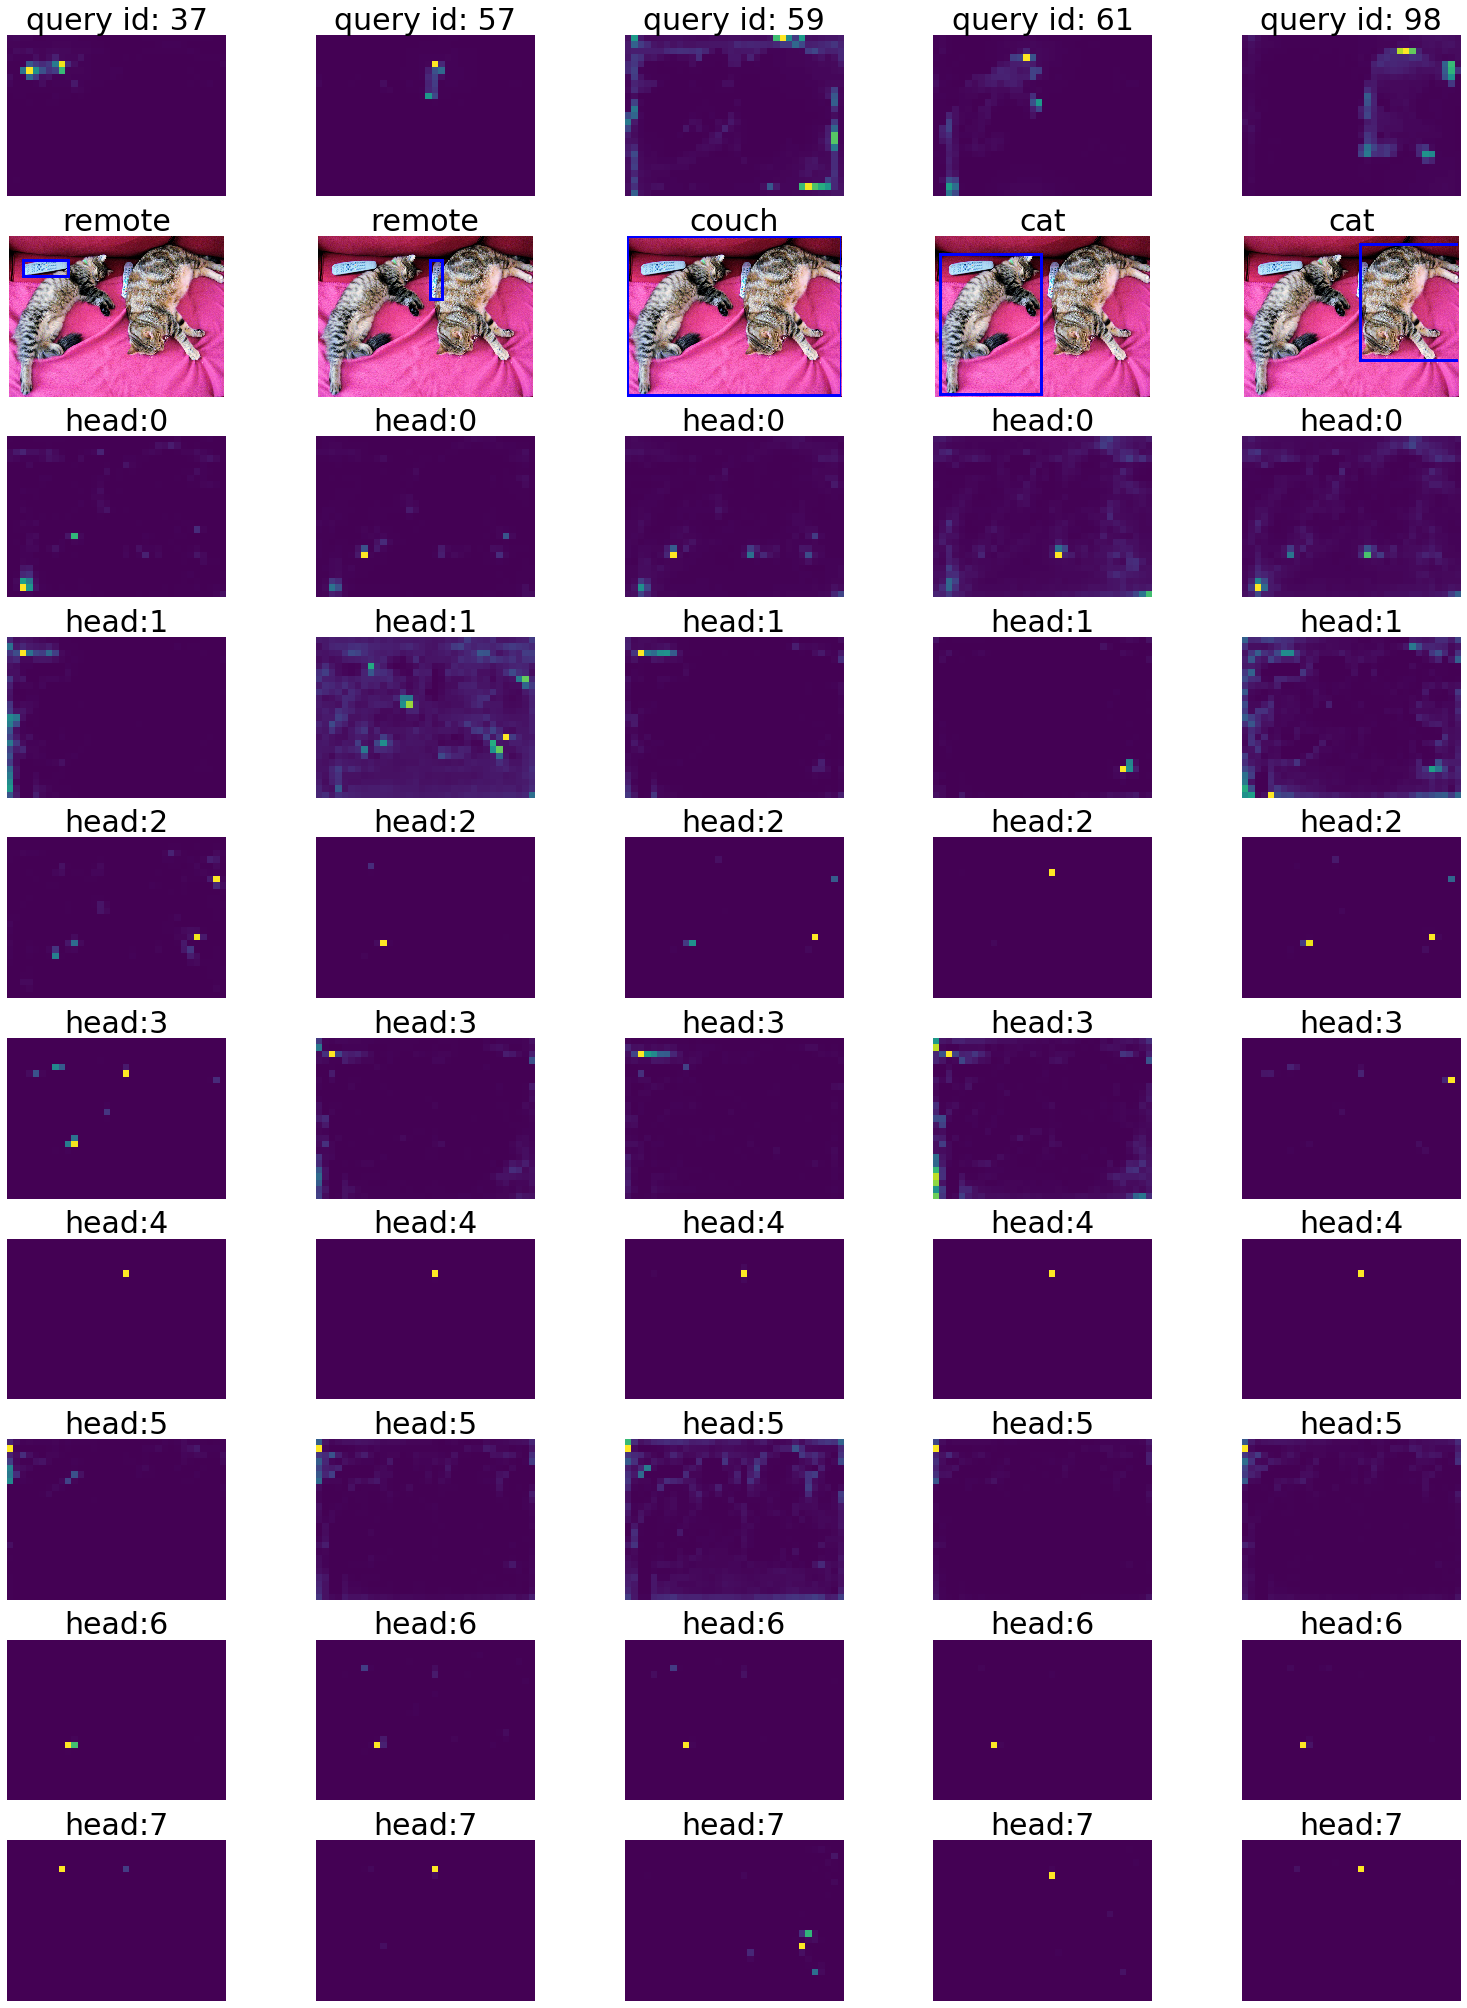

In [48]:
from predict_utils import COLORS
fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=10, figsize=(22, 28))  # [11,2]
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    # 可视化decoder的注意力权重
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}', fontsize=30)
    # 可视化框和类别
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()], fontsize=30)
    # 分别可视化8个头部的位置特征图
    for head in range(2, 2 + 8):
        ax = ax_i[head]
        ax.imshow(attn_every_heads[0, head - 2, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'head:{head - 2}', fontsize=30)
fig.tight_layout()  # 自动调整子图来使其填充整个画布
plt.show()

In [47]:
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='http://images.cocodataset.org/val2017/000000039769.jpg',
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # propagate through the model
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        # don't need the list anymore
        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        shape = self.conv_features['0'].tensors.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)
    
    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)
    
    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)
            
            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]
            
            axs[1].imshow(sattn_map, cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()
        
    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

In [100]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import math
w = AttentionVisualizer(model, transform)
w.run()